# stripers Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 28, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 49 # stripers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3350 entries, 0 to 3349
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              3350 non-null   int64  
 1   dimCustomerMasterId       3350 non-null   int64  
 2   customerNumber            3350 non-null   object 
 3   year                      3350 non-null   object 
 4   productGrouping           3350 non-null   object 
 5   totalSpent                3350 non-null   float64
 6   recentDate                3350 non-null   object 
 7   attendancePercent         3350 non-null   float64
 8   renewedBeforeDays         3350 non-null   int64  
 9   isBuyer                   3350 non-null   object 
 10  source_tenure             3350 non-null   int64  
 11  tenure                    3350 non-null   int64  
 12  distToVenue               0 non-null      object 
 13  totalGames                3350 non-null   int64  
 14  recency 

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'distToVenue',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3350 entries, 0 to 3349
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          3350 non-null   int64  
 1   dimCustomerMasterId   3350 non-null   int64  
 2   customerNumber        3350 non-null   object 
 3   year                  3350 non-null   object 
 4   productGrouping       3350 non-null   object 
 5   totalSpent            3350 non-null   float64
 6   recentDate            3350 non-null   object 
 7   attendancePercent     3350 non-null   float64
 8   renewedBeforeDays     3350 non-null   int64  
 9   isBuyer               3350 non-null   object 
 10  source_tenure         3350 non-null   int64  
 11  tenure                3350 non-null   int64  
 12  totalGames            3350 non-null   int64  
 13  recency               3350 non-null   int64  
 14  missed_games_1        3350 non-null   int64  
 15  missed_games_2       

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (3015, 46)
Unseen Data For Predictions: (335, 46)
Data for Modeling (A Class): (3015, 46)
Unseen Data For Predictions: (335, 46)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(3350, 18)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3350 entries, 0 to 3349
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   attendancePercent    3350 non-null   float64
 1   renewedBeforeDays    3350 non-null   int64  
 2   source_tenure        3350 non-null   int64  
 3   tenure               3350 non-null   int64  
 4   totalGames           3350 non-null   int64  
 5   missed_games_1       3350 non-null   int64  
 6   missed_games_2       3350 non-null   int64  
 7   missed_games_over_2  3350 non-null   int64  
 8   isNextYear_Buyer     3350 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 235.7 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [8]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,attendancePercent,renewedBeforeDays,source_tenure,tenure,totalGames,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer
attendancePercent,1.00,-0.37,-0.08,0.02,0.27,0.31,0.13,-0.12,0.05
renewedBeforeDays,-0.37,1.00,0.27,0.10,0.17,0.01,0.05,0.09,0.15
source_tenure,-0.08,0.27,1.00,-0.03,0.22,0.20,0.22,0.17,0.17
tenure,0.02,0.10,-0.03,1.00,0.19,0.03,0.04,0.14,0.11
totalGames,0.27,0.17,0.22,0.19,1.00,0.59,0.51,0.58,0.30
missed_games_1,0.31,0.01,0.20,0.03,0.59,1.00,0.53,0.33,0.17
missed_games_2,0.13,0.05,0.22,0.04,0.51,0.53,1.00,0.44,0.20
missed_games_over_2,-0.12,0.09,0.17,0.14,0.58,0.33,0.44,1.00,0.27
isNextYear_Buyer,0.05,0.15,0.17,0.11,0.30,0.17,0.20,0.27,1.00


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [9]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (2680, 9)
Unseen Data For Predictions: (670, 9)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [10]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,7918
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(2680, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


('lightgbm',
 'box-cox',
 [('Setup Config',
                                  Description             Value
   0                               session_id              7918
   1                                   Target  isNextYear_Buyer
   2                              Target Type            Binary
   3                            Label Encoded        0: 0, 1: 1
   4                            Original Data         (2680, 9)
   5                           Missing Values             False
   6                         Numeric Features                 8
   7                     Categorical Features                 0
   8                         Ordinal Features             False
   9                High Cardinality Features             False
   10                 High Cardinality Method              None
   11                   Transformed Train Set         (2144, 8)
   12                    Transformed Test Set          (536, 8)
   13                      Shuffle Train-Test              T

In [11]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
9,Extreme Gradient Boosting,0.7365,0.8126,0.6468,0.6703,0.6579,0.4438,0.4443,0.4170
2,Gradient Boosting Classifier,0.7313,0.7999,0.5897,0.6828,0.6317,0.4223,0.4259,0.0580
7,Random Forest Classifier,0.7304,0.7997,0.6289,0.6682,0.6463,0.4291,0.4310,0.1980
5,Light Gradient Boosting Machine,0.7271,0.8156,0.6206,0.6635,0.6409,0.4213,0.4224,0.0280
3,Extra Trees Classifier,0.7141,0.7818,0.6123,0.6458,0.6272,0.3958,0.3973,0.1970
1,Decision Tree Classifier,0.7090,0.6976,0.6409,0.6272,0.6330,0.3922,0.3931,0.0060
0,Ada Boost Classifier,0.7071,0.7626,0.5672,0.6430,0.6023,0.3721,0.3741,0.0380
8,NGBClassifier,0.6977,0.7776,0.5552,0.6312,0.5896,0.3522,0.3549,0.7860
6,Logistic Regression,0.6758,0.7210,0.3875,0.6480,0.4833,0.2684,0.2883,0.0440
4,K Neighbors Classifier,0.6320,0.6831,0.4994,0.5347,0.5156,0.2196,0.2205,0.0470


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [12]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7163,0.8046,0.6667,0.6292,0.6474,0.4104,0.4109
1,0.7442,0.8152,0.6429,0.6835,0.6626,0.4569,0.4575
2,0.7721,0.8322,0.6905,0.7160,0.7030,0.5182,0.5184
3,0.7535,0.8152,0.6706,0.6951,0.6826,0.4812,0.4814
4,0.7383,0.8233,0.6310,0.6795,0.6543,0.4443,0.4450
5,0.7617,0.8121,0.6786,0.7037,0.6909,0.4971,0.4973
6,0.6776,0.7607,0.5476,0.5974,0.5714,0.3138,0.3145
7,0.7430,0.8313,0.6310,0.6883,0.6584,0.4530,0.4541
8,0.7243,0.8071,0.6190,0.6582,0.6380,0.4157,0.4162
9,0.7336,0.8239,0.6905,0.6517,0.6705,0.4473,0.4478


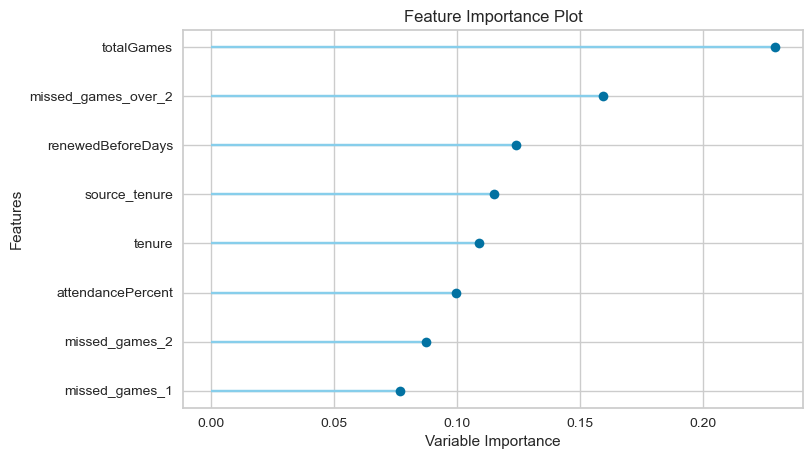

In [13]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?